# 第6章 支持向量机

> 推荐阅读：
>
> [详解支持向量机](https://zhuanlan.zhihu.com/p/29604517)
>
> [由浅入深了解支持向量机](https://blog.csdn.net/v_july_v/article/details/7624837)

支持向量机（Support Vector Machines，SVM）有很多实现，但是本章只关注其中最流行的一种实现，即序列最小优化（Sequential Minimal Optimization，SMO一种求解支持向量机二次规划的算法）算法。

在此之后，将介绍如何使用一种称为核函数（kernel）的方式将SVM扩展到更多数据集上。最后会回顾第1章中手写识别的例子，并考察其能否通过SVM来提高识别的效果。

> 优点：泛化错误率低，计算开销不大，结果易解释。
>
> 缺点：对参数调节和核函数的选择敏感，原始分类器不加修改仅适用于处理二类问题。
>
> 适用数据类型：数值型和标称型数据。

对于线性可分的数据集，整体过程可以简述为：

本质是先确定支持向量$\alpha$集合，再由支持向量反推出超平面的$w$和$b$


## 6.1 超平面与支持向量

在第五章中，我们的数据很容易就可以在图中画出一条直线将两组数据分开，这组数据被称为线性可分（linearly separable）数据。分隔开来的直线称为分隔超平面（separating hyperplane）。

数据点都在二维平面上，所以此时分隔超平面就只是一条直线。但是，如果所给的数据集是三维的，那么此时用来分隔数据的就是一个平面。

对于一个N维的数据，就存在一个N-1维的超平面。

对于数据构建一个分类器，如果数据点离决策边界越远，那么其最后的预测结果也就越可信。数据点到分隔面的距离被称为间隔（margin）。间隔应该尽可能地大，这样分类器泛化能力更强。

**支持向量**（support vector）就是离分隔超平面最近的那些点。接下来要试着**最大化支持向量到分隔面的距离**。

## 6.2 寻找最大间隔

分隔超平面的形式可以写成$f(x)=w^Tx+b$。

要计算点 A到分隔超平面的几何距离，就必须给出点到分隔面的法线或垂线的长度（几何间隔），该值为
$$
\frac{|w^TA+b|}{||w||}=\frac{f(A)}{||w||}
$$

> 此处写的比较简略，推导过程可参考：
>
> 1. [由浅入深了解支持向量机](https://blog.csdn.net/v_july_v/article/details/7624837)
> 2. [为什么超平面的法向量刚好是w](https://blog.csdn.net/Ocean_waver/article/details/105653904)

### 6.2.1 分类器求解的优化问题

与逻辑回归的sigmoid分类器不同，支持向量机的分类器是-1和1，而不是0和1；这样做带来了很多数学计算上的好处：

1. 对于任意一点，它的函数间隔$yf(x)$始终为正的

在6.2中我们已知几何间隔就是$\frac{f(A)}{||w||}$，即函数间隔除以超平面法向量的模。为了最优化超平面的$w$和$b$的参数，我们需要找到支持向量，并对支持向量与超平面的几何间隔最大化。

我们令支持向量的函数间隔等于1，即$f(A)=1$（[为什么可以这么做](https://blog.csdn.net/williamchin/article/details/116590902)），那么现在几何距离为：
$$
\gamma=\frac{1}{||w||} \quad s.t.\quad  y_i(w^Tx_i+b)\ge1,i=1,...,n
$$

> $s.t.$意思是subject to：服从于，约束于的意思。

相当于在后面的约束条件下最大化$\gamma=\frac{1}{||w||}$，相当于求$\frac{1}{2}||w||^2$的最小值（$\frac{1}{2}$只是计算上的方便）。
$$
\gamma=\frac{1}{2}||w||^2 \quad s.t.\quad  y_i(w^Tx_i+b)\ge1,i=1,...,n
$$
我们知道我们要求解的是最小化问题，所以一个直观的想法是如果我能够构造一个函数，使得该函数在可行解区域内与原目标函数完全一致，而在可行解区域外的数值非常大，甚至是无穷大，那么这个**没有约束条件的新目标函数的优化问题**就与原来**有约束条件的原始目标函数的优化问题**是等价的问题。这就是使用拉格朗日方程的目的，它将约束条件放到目标函数中，**从而将有约束优化问题转换为无约束优化问题。**

随后，人们又发现，使用拉格朗日获得的函数，使用求导的方法求解依然困难。进而，需要对问题再进行一次转换，即使用一个数学技巧：**拉格朗日对偶。**

所以，显而易见的是，我们在拉格朗日优化我们的问题这个道路上，**需要进行下面二个步骤：**

- 将有约束的原始目标函数转换为无约束的新构造的拉格朗日目标函数
- 使用拉格朗日对偶性，将不易求解的优化问题转化为易求解的优化

下面，进行第一步：**将有约束的原始目标函数转换为无约束的新构造的拉格朗日目标函数**

公式变形如下：
$$
L(w,b,\alpha)=\frac{1}{2}||w||^2-\sum_{i=1}^n\alpha_i(y_i(w^Tx_i+b)-1)
$$
当样本点不满足约束条件时，我们将$α_i$设置为正无穷，此时函数显然也是正无穷；当样本点满足约束条件时，$α_i=0$。至此建立一个在可行解区域内与原目标函数相同，在可行解区域外函数值趋近于无穷大的新函数。

因为

此时我们的问题，由$min\frac{1}{2}||w||^2$变成了$minL(w,b,\alpha)$

> 没有约束条件，直接导数等于0或者梯度下降法；约束条件是等式的写成拉格朗日函数，再分别求导求其值。最麻烦的就是约束条件是不等式的：除了写成拉格朗日函数，还需要KKT条件。

此外，由于这个问题的特殊结构，还可以通过拉格朗日对偶性（Lagrange Duality）变换到对偶变量 (dual variable) 的优化问题，即通过求解与原问题等价的对偶问题（dual problem）得到原始问题的最优解，这就是线性可分条件下支持向量机的对偶算法，这样做的优点在于：一者对偶问题往往更容易求解；二者可以自然的引入核函数，进而推广到非线性分类问题(不能用一根线解决的问题)。

那什么是拉格朗日对偶性呢？简单来讲，**通过给每一个约束条件加上一个拉格朗日乘子**（Lagrange multiplier）$\alpha$，定义拉格朗日函数（通过拉格朗日函数将约束条件融合到目标函数里去，从而只用一个函数表达式便能清楚的表达出我们的问题)：


> 关于拉格朗日乘子的知识，请参考：[如何理解拉格朗日乘子](https://www.matongxue.com/madocs/939)

后续还需要将公式继续依据拉格朗日对偶性继续变化，因笔者能力有限，没有办法完成详细的公式推导，[总结来说](https://zhuanlan.zhihu.com/p/73205416)推导过程为：

SVM它本质上即是一个分类方法，用 $w^T+b$ 定义分类函数，于是求$w、b$，为寻最大间隔，引出$\frac{1}{2}||w||^2$，继而引入拉格朗日因子，化为对拉格朗日乘子$\alpha$的求解（求解过程中会涉及到一系列最优化或凸二次规划等问题），如此，求w.b与求$\alpha$等价，而$\alpha$的求解可以用一种快速学习算法SMO，至于核函数，是为处理非线性情况，若直接映射到高维计算恐维度爆炸，故在低维计算，等效高维表现。

最终的公式为：
$$
max_a[\sum_{i=1}^{m}\alpha-\frac{1}{2}\sum_{i,j=1}^{m}label^{(i)}·label^{(j)}·\alpha_i·\alpha_j \langle x^{(i)},x^{(j)} \rangle]  \quad s.t.\quad C\ge\alpha\ge0, \quad \sum_{i-1}^{m}\alpha_i·label^{(i)}=0
$$


## 6.3 SMO简化版代码实现

[参考链接](https://github.com/Jack-Cherish/Machine-Learning/blob/master/SVM/svm-simple.py)

SMO算法，用于训练SVM。SMO表示序列最小优化（Sequential Minimal Optimization）。SMO算法是将大优化问题分解为多个小优化问题来求解的。这些小优化问题往往很容易求解，并且对它们进行顺序求解的结果与将它们作为整体来求解的结果是完全一致的。在结果完全相同的同时，SMO算法的求解时间短很多。 

SMO算法的目标是求出一系列$\alpha$和$b$，一旦求出了这些$\alpha$，其中$\alpha$向量中不为0的项就对应了样本数据集的支持向量，基于支持向量，就很容易计算出权重向量w并得到分隔超平面。 

SMO算法的工作原理是：每次循环中选择两个alpha进行优化处理。一旦找到一对合适的alpha，那么就增大其中一个同时减小另一个。这里所谓的“合适”就是指两个alpha必须要符合一定的条件，条件之一就是这两个alpha必须要在间隔边界之外，而其第二个条件则是这两个alpha还没有进行过区间化处理或者不在边界上。

首先在数据集上遍历每一个alpha（即样本中的某条数据），然后在剩下的alpha集合中随机选择另一个alpha，从而构
建alpha对。由于改变一个alpha可能会导致该约束条件失效，因此我们总是同时改变两个alpha。



In [17]:
import numpy as np
import random
import matplotlib.pyplot as plt
"""
函数说明:简化版SMO算法
Parameters:
    dataMatIn - 数据矩阵
    classLabels - 数据标签
    C - 松弛变量
    toler - 容错率
    maxIter - 最大迭代次数
Returns:
    无
"""
def smoSimple(dataMatIn, classLabels, C, toler, maxIter):
    #转换为numpy的mat存储
	dataMatrix = np.mat(dataMatIn); labelMat = np.mat(classLabels).transpose()
	#初始化b参数，统计dataMatrix的维度
	b = 0; m,n = np.shape(dataMatrix)
	#初始化alpha参数，设为0
	alphas = np.mat(np.zeros((m,1)))
	#初始化迭代次数
	iter_num = 0
	#最多迭代matIter次
	while (iter_num < maxIter):
		alphaPairsChanged = 0
		for i in range(m):
			#步骤1：计算误差Ei
			fXi = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[i,:].T)) + b
			Ei = fXi - float(labelMat[i])
			#优化alpha，设定一定的容错率。
			if ((labelMat[i]*Ei < -toler) and (alphas[i] < C)) or ((labelMat[i]*Ei > toler) and (alphas[i] > 0)):
				#随机选择另一个与alpha_i成对优化的alpha_j
				j = selectJrand(i,m)
				#步骤1：计算误差Ej
				fXj = float(np.multiply(alphas,labelMat).T*(dataMatrix*dataMatrix[j,:].T)) + b
				Ej = fXj - float(labelMat[j])
				#保存更新前的aplpha值，使用深拷贝
				alphaIold = alphas[i].copy(); alphaJold = alphas[j].copy();
				#步骤2：计算上下界L和H
				if (labelMat[i] != labelMat[j]):
				    L = max(0, alphas[j] - alphas[i])
				    H = min(C, C + alphas[j] - alphas[i])
				else:
				    L = max(0, alphas[j] + alphas[i] - C)
				    H = min(C, alphas[j] + alphas[i])
				if L==H: print("L==H"); continue
				#步骤3：计算eta
				eta = 2.0 * dataMatrix[i,:]*dataMatrix[j,:].T - dataMatrix[i,:]*dataMatrix[i,:].T - dataMatrix[j,:]*dataMatrix[j,:].T
				if eta >= 0: print("eta>=0"); continue
				#步骤4：更新alpha_j
				alphas[j] -= labelMat[j]*(Ei - Ej)/eta
				#步骤5：修剪alpha_j
				alphas[j] = clipAlpha(alphas[j],H,L)
				if (abs(alphas[j] - alphaJold) < 0.00001): print("alpha_j变化太小"); continue
				#步骤6：更新alpha_i
				alphas[i] += labelMat[j]*labelMat[i]*(alphaJold - alphas[j])
				#步骤7：更新b_1和b_2
				b1 = b - Ei- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[i,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[i,:]*dataMatrix[j,:].T
				b2 = b - Ej- labelMat[i]*(alphas[i]-alphaIold)*dataMatrix[i,:]*dataMatrix[j,:].T - labelMat[j]*(alphas[j]-alphaJold)*dataMatrix[j,:]*dataMatrix[j,:].T
				#步骤8：根据b_1和b_2更新b
				if (0 < alphas[i]) and (C > alphas[i]): b = b1
				elif (0 < alphas[j]) and (C > alphas[j]): b = b2
				else: b = (b1 + b2)/2.0
				#统计优化次数
				alphaPairsChanged += 1
				#打印统计信息
				print("第%d次迭代 样本:%d, alpha优化次数:%d" % (iter_num,i,alphaPairsChanged))
		#更新迭代次数
		if (alphaPairsChanged == 0): iter_num += 1
		else: iter_num = 0
		print("迭代次数: %d" % iter_num)
	return b,alphas

为了运行上述代码，我们需要做一些数据载入的准备工作。

In [6]:
"""
函数说明:读取数据
Parameters:
    fileName - 文件名
Returns:
    dataMat - 数据矩阵
    labelMat - 数据标签
"""
def loadDataSet(fileName):
	dataMat = []; labelMat = []
	fr = open(fileName)
	for line in fr.readlines():                                     #逐行读取，滤除空格等
		lineArr = line.strip().split('\t')
		dataMat.append([float(lineArr[0]), float(lineArr[1])])      #添加数据
		labelMat.append(float(lineArr[2]))                          #添加标签
	return dataMat,labelMat

"""
函数说明:随机选择alpha
Parameters:
    i - alpha_i的索引值
    m - alpha参数个数
Returns:
    j - alpha_j的索引值
"""
def selectJrand(i, m):
	j = i                                 #选择一个不等于i的j
	while (j == i):
		j = int(random.uniform(0, m))
	return j


"""
函数说明:修剪alpha
Parameters:
    aj - alpha_j值
    H - alpha上限
    L - alpha下限
Returns:
    aj - alpah值
"""
def clipAlpha(aj,H,L):
	if aj > H: 
		aj = H
	if L > aj:
		aj = L
	return aj


然后运行代码

In [13]:
dataMat, labelMat = loadDataSet('data/Ch06/testSet.txt')
b,alphas = smoSimple(dataMat, labelMat, 0.6, 0.001, 40)

L==H
L==H
L==H
L==H
第0次迭代 样本:4, alpha优化次数:1
第0次迭代 样本:5, alpha优化次数:2
L==H
L==H
L==H
第0次迭代 样本:46, alpha优化次数:3
alpha_j变化太小
L==H
第0次迭代 样本:57, alpha优化次数:4
第0次迭代 样本:69, alpha优化次数:5
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
L==H
L==H
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第1次迭代 样本:86, alpha优化次数:1
alpha_j变化太小
迭代次数: 0
L==H
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:97, alpha优化次数:1
迭代次数: 0
alpha_j变化太小
第0次迭代 样本:4, alpha优化次数:1
alpha_j变化太小
第0次迭代 样本:7, alpha优化次数:2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
L==H
alpha_j变化太小
L==H
alpha_j变化太小
alpha_j变化太小
L==H
第0次迭代 样本:46, alpha优化次数:3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
第0次迭代 样本:69, a

迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
第2次迭代 样本:23, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
第1次迭代 样本:17, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
第5次迭代 样本:54, alpha优化次数:1
alpha_j变化太小
迭代次数: 0
第0次迭代 样本:17, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
第3次迭代 样本:52, alpha优化次数:1
alpha_j变化太小
alpha_j变化太小
迭代次数: 0
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 1
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 2
alpha_j变化太小
alpha_j变化太小
alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
alpha_j

alpha_j变化太小
迭代次数: 3
alpha_j变化太小
alpha_j变化太小
迭代次数: 4
alpha_j变化太小
alpha_j变化太小
迭代次数: 5
alpha_j变化太小
alpha_j变化太小
迭代次数: 6
alpha_j变化太小
alpha_j变化太小
迭代次数: 7
alpha_j变化太小
alpha_j变化太小
迭代次数: 8
alpha_j变化太小
alpha_j变化太小
迭代次数: 9
alpha_j变化太小
alpha_j变化太小
迭代次数: 10
alpha_j变化太小
alpha_j变化太小
迭代次数: 11
alpha_j变化太小
alpha_j变化太小
迭代次数: 12
alpha_j变化太小
alpha_j变化太小
迭代次数: 13
alpha_j变化太小
alpha_j变化太小
迭代次数: 14
alpha_j变化太小
alpha_j变化太小
迭代次数: 15
alpha_j变化太小
alpha_j变化太小
迭代次数: 16
alpha_j变化太小
alpha_j变化太小
迭代次数: 17
alpha_j变化太小
alpha_j变化太小
迭代次数: 18
alpha_j变化太小
alpha_j变化太小
迭代次数: 19
alpha_j变化太小
迭代次数: 20
alpha_j变化太小
迭代次数: 21
alpha_j变化太小
迭代次数: 22
alpha_j变化太小
迭代次数: 23
alpha_j变化太小
迭代次数: 24
alpha_j变化太小
迭代次数: 25
alpha_j变化太小
迭代次数: 26
alpha_j变化太小
迭代次数: 27
alpha_j变化太小
迭代次数: 28
alpha_j变化太小
迭代次数: 29
alpha_j变化太小
迭代次数: 30
alpha_j变化太小
迭代次数: 31
alpha_j变化太小
迭代次数: 32
alpha_j变化太小
迭代次数: 33
alpha_j变化太小
迭代次数: 34
alpha_j变化太小
迭代次数: 35
alpha_j变化太小
迭代次数: 36
alpha_j变化太小
迭代次数: 37
alpha_j变化太小
迭代次数: 38
alpha_j变化太小
迭代次数: 39
alpha_j变化太小
迭代次数: 40


我们将运行的结果图形化展示出来

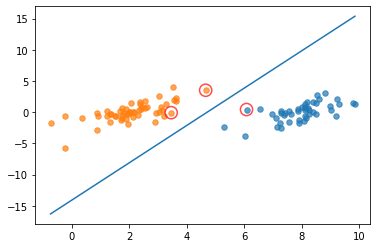

In [18]:
def get_w(dataMat, labelMat, alphas):
    alphas, dataMat, labelMat = np.array(alphas), np.array(dataMat), np.array(labelMat)
    w = np.dot((np.tile(labelMat.reshape(1, -1).T, (1, 2)) * dataMat).T, alphas)
    return w.tolist()


def showClassifer(dataMat, w, b):
	#绘制样本点
	data_plus = []                                  #正样本
	data_minus = []                                 #负样本
	for i in range(len(dataMat)):
		if labelMat[i] > 0:
			data_plus.append(dataMat[i])
		else:
			data_minus.append(dataMat[i])
	data_plus_np = np.array(data_plus)              #转换为numpy矩阵
	data_minus_np = np.array(data_minus)            #转换为numpy矩阵
	plt.scatter(np.transpose(data_plus_np)[0], np.transpose(data_plus_np)[1], s=30, alpha=0.7)   #正样本散点图
	plt.scatter(np.transpose(data_minus_np)[0], np.transpose(data_minus_np)[1], s=30, alpha=0.7) #负样本散点图
	#绘制直线
	x1 = max(dataMat)[0]
	x2 = min(dataMat)[0]
	a1, a2 = w
	b = float(b)
	a1 = float(a1[0])
	a2 = float(a2[0])
	y1, y2 = (-b- a1*x1)/a2, (-b - a1*x2)/a2
	plt.plot([x1, x2], [y1, y2])
	#找出支持向量点
	for i, alpha in enumerate(alphas):
		if abs(alpha) > 0:
			x, y = dataMat[i]
			plt.scatter([x], [y], s=150, c='none', alpha=0.7, linewidth=1.5, edgecolor='red')
	plt.show()

w = get_w(dataMat, labelMat, alphas)
showClassifer(dataMat, w, b)

## 6.4 完整SMO算法

todo

## 6.5 核函数



什么是核函数，什么是核方法呢？我们将低维空间的样本向高维空间映射，这便是核方法，而将映射后的向量进行內积得到的函数$K(s_{i},s_{j}) $称为核函数（kernel function）。核函数最后其实就是关于原低维空间各维度坐标值的函数。

当我们需要先对数据做转换，然后求内积的时候，这样的一系列操作往往成本过高（有时候根本不可能，因为我们可能想要升到无穷维）。因此我们可以直接定义一个核函数 K 直接求出做转换后求内积的结果，从而降低运算量。

[参考链接](https://www.zhihu.com/question/24627666/answer/1085861632)

> 还是在低维上计算，然后通过一个函数将计算结果映射到高维。这样做避免了直接映射到高维后，计算量暴增的问题。


### 6.5.1常用核函数
线性核（Linear核）多项式核 （Polynomial核）高斯核（RBF核 / 径向基核）

最常用的是 Linear核函数 和 高斯核函数

### 6.5.2 核函数的选择

（以下观点来自吴恩达）如果 Feature 的数量很大，跟样本数量差不多，这时候选用 LR 或者是 Linear Kernel 的 SVM；

如果 Feature 的数量比较小，样本数量一般，不算大也不算小，选用 SVM+Gaussian Kernel

如果 Feature 的数量比较小，而样本数量很多，需要手工添加一些 feature 变成第一种情况即：

如果特征维数很高，往往线性可分（SVM 解决非线性分类问题的思路就是将样本映射到更高维的特征空间中），可以采用 LR 或者线性核的 SVM；

如果样本数量很多，由于求解最优化问题的时候，目标函数涉及两两样本计算内积，使用高斯核明显计算量会大于线性核，所以手动添加一些特征，使得线性可分，然后可以用 LR 或者线性核的 SVM；如果不满足上述两点，即特征维数少，样本数量正常，可以使用高斯核的 SVM。




## 6.6 本章小结

与Logistic不同，SVM使用的激活函数是-1 1 阶跃函数；最重要的找到超平面附近的支持向量。使用SMO算法，求出的权重向量中，不为0的项即为支持向量，然后依据支持向量，最大化超平面与SV的距离，求出最佳超平面。

对于线性不可分的数据集，则使用核函数，映射到高维。